# EKF Localization

In [25]:
%matplotlib inline

import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys

# matplotlib.style.use('ggplot')
matplotlib.style.use('default')

In [26]:
from google.colab import drive
drive.mount("/content/drive/")
sys.path.append("/content/drive/My Drive/Colab Notebooks")
!ls "/content/drive/My Drive/Colab Notebooks"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
'08-Designing-Kalman-Filters (1).ipynb'       lab2.ipynb	    Untitled1.ipynb
'08-Designing-Kalman-Filters (2).ipynb'       lab3.ipynb	   'Untitled (2)'
'08-Designing-Kalman-Filters (3) (1).ipynb'   lab4.ipynb	    Untitled2.ipynb
'08-Designing-Kalman-Filters (3).ipynb'       lab5.ipynb	   'Untitled (3)'
'08-Designing-Kalman-Filters (4).ipynb'       lab6.ipynb	    Untitled3.ipynb
'08-Designing-Kalman-Filters (5).ipynb'       lab7.ipynb	   'Untitled (4)'
 08-Designing-Kalman-Filters.ipynb	      state_meas_data.mat   Untitled4.ipynb
 ervaDeneme.ipynb			      Untitled		    Untitled5.ipynb
 erva_karabulut_ekf_coursework.ipynb	      Untitled0.ipynb	    Untitled6.ipynb
'ft_example_roberta (1).ipynb'		     'Untitled (1)'	    Untitled7.ipynb
 ft_example_roberta.ipynb		      Untitled10.ipynb	    Untitled8.ipynb
 Lab1.ipynb				      Untitled11.ipynb	    Untitled9.ipynb

## Introduction

This coursework is about simulation of robot localization problem based on extended kalman filter (EKF).


In this simulation, the robot has a state vector which includes 4 states at time t,
$\textbf{x}_t=[x_t, y_t, \phi_t, v_t]$
where
$x_t$, $y_t$ are a 2D x-y position, $\phi_t$ is orientation (yaw angle), and $v_t$ is velocity. Covariace matrix of the state is given by $\textbf{P}_t$.  The initial state covariance matrix at time t = 0 can be given as

\begin{equation*} \mathbf P_0 = \begin{bmatrix} \sigma^2_{p_x} & 0 & 0 & 0 \\ 0 & \sigma^2_{p_y} & 0 & 0 \\ 0 & 0 & \sigma^2_{p_\phi} & 0 \\ 0 & 0 & 0 & \sigma^2_{p_v} \end{bmatrix} \end{equation*}

where $\sigma^2$ is a variance.



The robot has a Speed sensor and a Gyro sensor i.e. sensor fusion. So, the control input vector can be used at each
time step t,
$\textbf{u}_t=[v_t, \omega_t]$
where $v_t$ is velocity and $\omega_t$ (pronounced as omega_t) is angular velocity (yaw rate).

Also, the robot has a Global Navigation Satellite System (GNSS) sensor. This means that the robot can observe x-y
position at each time t.
$\textbf{z}_t=[x_t,y_t]$

The control input vector and observation vector include their corresponding sensor noise. Hence, we consider additive Gaussian noise.


## Process Model

We model the process or system as a non-linear robot motion model plus a noise.

$\textbf{x}_{t+1} = f(\textbf{x}_t, \textbf{u}_t) + w_x$

where $w_x$ is a zero-mean Gaussian white noise with covariance matrix $\textbf{Q}$ i.e. $w_x = \mathcal{N} (0, \textbf{Q})$. The process noise covariance matrix $\textbf{Q}$ can be given as

\begin{equation*} \mathbf Q = \begin{bmatrix} \sigma^2_{q_x} & 0 & 0 & 0 \\ 0 & \sigma^2_{q_y} & 0 & 0 \\ 0 & 0 & \sigma^2_{q_\phi} & 0 \\ 0 & 0 & 0 & \sigma^2_{q_v} \end{bmatrix} \end{equation*}


The non-linear robot motion function is given as

\begin{equation*} \begin{bmatrix} x' \\ y' \\ \phi' \\ v' \end{bmatrix} = f(\textbf{x}, \textbf{u}) = \begin{bmatrix} x + v\cos(\phi)\Delta t \\ y + v\sin(\phi)\Delta t \\ \phi + \omega \Delta t \\ v \end{bmatrix} \end{equation*}

$\Delta_t$ is a time interval. Note that $v$ is the velocity from the control input.


The Jacobian matrix of $f$ is


\begin{equation*} J_f = \frac{\partial f(\mathbf x, \mathbf u)}{\partial \mathbf x} = \begin{bmatrix} \frac{\partial f_1}{\partial x_1}& \frac{\partial f_1}{\partial x_2} & \frac{\partial f_1}{\partial x_3} & \frac{\partial f_1}{\partial x_4}\\ \frac{\partial f_2}{\partial x_1}& \frac{\partial f_2}{\partial x_2} & \frac{\partial f_2}{\partial x_3} & \frac{\partial f_2}{\partial x_4}\\ \frac{\partial f_3}{\partial x_1}& \frac{\partial f_3}{\partial x_2} & \frac{\partial f_3}{\partial x_3} & \frac{\partial f_3}{\partial x_4}\\ \frac{\partial f_4}{\partial x_1}& \frac{\partial f_4}{\partial x_2} & \frac{\partial f_4}{\partial x_3} & \frac{\partial f_4}{\partial x_4} \end{bmatrix} \end{equation*}

\begin{equation*} = \begin{bmatrix} \frac{\partial x'}{\partial x}& \frac{\partial x'}{\partial y} & \frac{\partial x'}{\partial \phi} & \frac{\partial x'}{\partial v}\\ \frac{\partial y'}{\partial x}& \frac{\partial y'}{\partial y} & \frac{\partial y'}{\partial \phi} & \frac{\partial y'}{\partial v}\\ \frac{\partial \phi'}{\partial x}& \frac{\partial \phi'}{\partial y} & \frac{\partial \phi'}{\partial \phi} & \frac{\partial \phi'}{\partial v}\\ \frac{\partial v'}{\partial x}& \frac{\partial v'}{\partial y} & \frac{\partial v'}{\partial \phi} & \frac{\partial v'}{\partial v} \end{bmatrix} \end{equation*}


\begin{equation*} = \begin{bmatrix} 1& 0 & -v \sin(\phi) \Delta t & \cos(\phi) \Delta t\\ 0 & 1 & v \cos(\phi) \Delta t & \sin(\phi) \Delta t\\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} \end{equation*}

<!-- \begin{equation*} = \begin{bmatrix} &  &  &  \\
                                    &  &  &  \\
                                    &  &  &  \\
                                    &  &  &  \end{bmatrix} \end{equation*} -->

\\

Note that the state transition matrix $\mathbf F$ is given as

$$
\begin{aligned}
\mathbf F
&= {\frac{\partial{f(\mathbf x, \mathbf u)}}{\partial{\mathbf x}}}\biggr|_{{\mathbf x_t},{\mathbf u_t}} \\
\end{aligned}
$$

## Observation Model

The robot can get x-y position infomation from GPS (GNSS).

So GPS or GNSS Observation model is given by

$\textbf{z}_{t} = h(\textbf{x}_t) + w_z$

where $w_z$ is a zero-mean Gaussian white noise with covariance matrix $\textbf{R}$ i.e. $w_z = \mathcal{N} (0, \textbf{R})$. The observation noise covariance matrix $\textbf{R}$ can be given as

\begin{equation*} \mathbf R = \begin{bmatrix} \sigma^2_{r_x} & 0  \\ 0 & \sigma^2_{r_y} \end{bmatrix} \end{equation*}


The observation function is given as

\begin{equation*} \begin{bmatrix} x' \\ y' \end{bmatrix} = h(\textbf{x}) = \begin{bmatrix} x \\ y \end{bmatrix} \end{equation*}

The Jacobian matrix of $h$ is

\begin{equation*} J_h =  \frac{\partial h(\mathbf x)}{\partial \mathbf x} = \begin{bmatrix} \frac{\partial h_1}{\partial x_1} & \frac{\partial h_1}{\partial x_2} & \frac{\partial h_1}{\partial x_3} & \frac{\partial h_1}{\partial x_4}\\ \frac{\partial h_2}{\partial x_1}& \frac{\partial h_2}{\partial x_2} & \frac{\partial h_2}{\partial x_3} & \frac{\partial h_2}{ \partial x_4}\\ \end{bmatrix} \end{equation*}

\begin{equation*} = \begin{bmatrix} \frac{\partial x'}{\partial x} & \frac{\partial x'}{\partial y} & \frac{\partial x'}{\partial \phi} & \frac{\partial x'}{\partial v}\\ \frac{\partial y'}{\partial x}& \frac{\partial y'}{\partial y} & \frac{\partial y'}{\partial \phi} & \frac{\partial y'}{ \partial v}\\ \end{bmatrix} \end{equation*}

\begin{equation*} = \begin{bmatrix} 1& 0 & 0 & 0\\ 0 & 1 & 0 & 0\\ \end{bmatrix} \end{equation*}

<!-- \begin{equation*} = \begin{bmatrix}   &  &   &  \\
                                      &  &   &  \\ \end{bmatrix} \end{equation*} -->


\\
Note that the measurement matrix $\mathbf H$ which maps the state space into the observation space is given as

$$
\begin{aligned}
\mathbf H &= \frac{\partial{h(\mathbf x})}{\partial{\mathbf x}}\biggr|_{\mathbf x_t}
\end{aligned}
$$


## EKF Algorithm

The EKF algorithm based on the above motion and observation functions can be summarized as follows:

$$\begin{array}{l|l}
\hline
& \boxed{\mathbf F = {\frac{\partial{f(\mathbf x, \mathbf u)}}{\partial{\mathbf x}}}\biggr|_{{\mathbf x_t},{\mathbf u_t}}} \\
\text{Predict} & \boxed{\mathbf{\bar x} = f(\mathbf x, \mathbf u)}  \\
 & \mathbf{\bar P} = \mathbf{FPF}^\mathsf{T}+\mathbf Q \\
\hline
& \boxed{\mathbf H = \frac{\partial{h(\mathbf x)}}{\partial{\mathbf x}}\biggr|_{\bar{\mathbf x}_t}} \\
\text{Update} & \mathbf{\bar{z}} = \boxed{h(\bar{\mathbf x})}\\
 & \mathbf{K} = \mathbf{\bar{P}H}^\mathsf{T} (\mathbf{H\bar{P}H}^\mathsf{T} + \mathbf R)^{-1} \\
 & \mathbf x=\mathbf{\bar{x}} +\mathbf{K} (\mathbf{z} - \mathbf{\bar{z}}) \\
 & \mathbf P= (\mathbf{I}-\mathbf{KH})\mathbf{\bar{P}} \\
 \hline
\end{array}$$

In this coursework, the following two pieces of code show a $\textbf{one line code}$ each equally since they are both numpy codes assigned to their corresponding single variable.

In [27]:
m = np.array([[3., 4.], [5., 6.]])
print(m)     # Is the same as
m = np.array([[3., 4],
              [5., 6]])
print(m)

[[3. 4.]
 [5. 6.]]
[[3. 4.]
 [5. 6.]]


PLease follow the $\textbf{instructions}$ given in the code. For instance, if the instruction says use one line of code, you $\textbf{MUST}$ use one line of code as your solution. You are also expected to comment your code properly where necessary. The equations of EKF given above needs to be used for its implementation in this coursework, which is a modification of the EKF given in the lecture slides (Lecture 8) considering additive process and observation noises.

You also need to fine-tune the necessary parameters for better as well as bad localization, such as $\textbf{Q}$, $\textbf{R}$, the noise ratio added to control input, and the noise ratio added to observation. You need to investigate under varying conditions: better and bad results, and why that happened. You need to support your results analysis using visualization. Analysis of correlation of states in a state vector using updated covariance from the last time step needs to be conducted as well.

In [28]:
# Simulation parameters
dt = 0.2  # delta_t, in second (s)
total_simulation_time = 65.0  # total simulation time, in second (s)

# Process noise covariance matrix
Q = np.diag([0.15, 0.15, np.deg2rad(1.0), 1.2]) ** 2

# Observation noise covariance matrix
R = np.diag([0.5, 0.5]) ** 2

In [29]:
def read_sensors(x_true, u):
  #account uncertainty with added noise
    control_input_noise = np.diag([1.20, np.deg2rad(45.0)]) ** 2
    gps_noise = np.diag([0.5, 0.5]) ** 2

    x_true = motion_function_f(x_true, u)

    # Add noise to gps x-y position
    z = observation_function_h(x_true) + gps_noise @ np.random.randn(2, 1)

    # Add noise to control input
    u = u + control_input_noise @ np.random.randn(2, 1)

    return x_true, z, u


In [30]:
def motion_function_f(x, u):
# motion model function to predict the next state of the robot
    x = np.array([[x[0,0]+u[0,0]*math.cos(x[2,0])*dt],
                  [x[1,0]+u[0,0]*math.sin(x[2,0])*dt],
                  [x[2,0]+u[1,0]*dt],
                  [u[0,0]]
                  ])

    return x

In [31]:
def observation_function_h(x):
#Observation Function to get x-y measurements
    z = x[0:2]

    return z

In [32]:
def jacobian_f(x, u):
    """
    Jacobian of motion function f
    """
    Jf = np.array([[1,0,-u[0,0]*math.sin(x[2,0])*dt, math.cos(x[2,0])*dt],
          [0,1,u[0,0]*math.cos(x[2,0])*dt, math.sin(x[2,0])*dt],
          [0,0,1,0],
          [0,0,0,1]])

    return Jf


In [33]:
def jacobian_h(x):
    """
    Jacobian of Observation function h
    """


    Jh = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])

    return Jh

In [34]:
def ekf(x_est, P_est, z, u):

    # Predict
    F = jacobian_f(x_est, u)  #Jacobian of motion function
    x_pred = motion_function_f(x_est, u)  #Predicted state
    P_pred = F @ P_est @ F.T + Q  #predicted covariance



    # Update
    H = jacobian_h(x_pred)  #jacobian of the observation function

    z_pred = observation_function_h(x_pred)  #predicted measurement

    K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)  #Kalman Gain
    x_est = x_pred + K @ (z-z_pred)  #updated state estimate
    P_est = (np.identity(4)- K @ H) @ P_pred  #updated covariance
    return x_est, P_est

In [35]:
def run_ekf():
    print(" Simulation has started ...")
#Run the EKF simulation and visualize the trajectories.
    # Initialize state Vector and covariance
    x_est = np.array([5.0, 5.0, 0.0, 0.0]).reshape(4, 1) # Initial estimated state
    x_true = np.array([5.0, 5.0, 0.0, 0.0]).reshape(4, 1) # Initial true state
    P_est = 1.15 * np.eye(4)  # Initial covariance matrix.

    true_trajectory = []
    observed_trajectory = []
    estimated_trajectory = []

    for _ in np.arange(0, total_simulation_time, dt):

        # Control input
        u = np.array([[0.95], [-0.085]]) # v is in m/s and omega is grad/s.

        # Get sensor readings
        x_true, z, u = read_sensors(x_true, u)

        # Apply EKF
        x_est, P_est = ekf(x_est, P_est, z, u)


        # Store trajectories for visualization
        true_trajectory.append([x_true[0,0], x_true[1,0]])
        observed_trajectory.append([z[0,0],z[1,0]])
        estimated_trajectory.append([x_est[0,0], x_est[1,0]])

    true_trajectory_arr = np.array(true_trajectory)
    observed_trajectory_arr = np.array(observed_trajectory)
    estimated_trajectory_arr = np.array(estimated_trajectory)

    # Plot the trajectories
    plt.figure(figsize=(10, 10))
    plt.plot(true_trajectory_arr[:, 0], true_trajectory_arr[:, 1], 'red', label='True Trajectory')
    plt.plot(observed_trajectory_arr[:, 0], observed_trajectory_arr[:, 1], 'green', label='Observed Trajectory')
    plt.plot(estimated_trajectory_arr[:, 0], estimated_trajectory_arr[:, 1], 'blue', label='Estimated Trajectory')



    return x_est, P_est

 Simulation has started ...


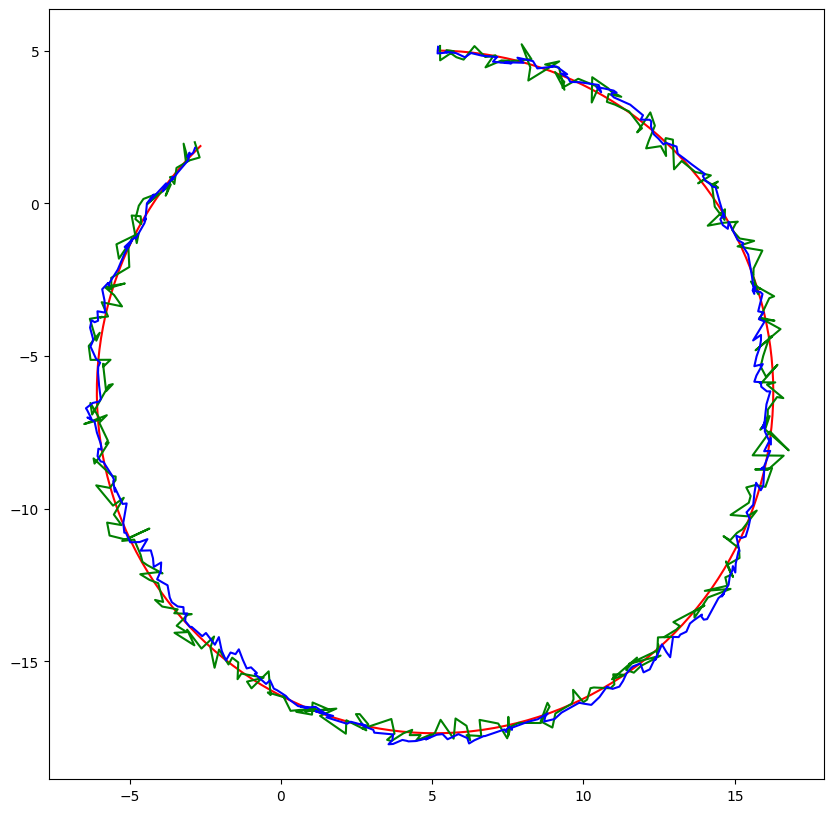

In [36]:
# Run the run_ekf() function
x_est, P_est = run_ekf()